In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy

# Custom modules
from S4 import *

In [3]:
# Load dataset
# Use the smaller test set to train faster
MNIST_TEST = datasets.MNIST(root='./../datasets', train=False, download=True, transform=transforms.ToTensor())

dataloader = DataLoader(MNIST_TEST, shuffle=True, batch_size=8)
testloader = DataLoader(MNIST_TEST, shuffle=False, batch_size=1)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# S4 Block

Here's a simple S4 Block that encapsulates the base S4 layer with layer norm, activation and linear projection.

In [5]:
def Block(signal_dim: int, state_dim: int):
    return Residual(
        S4Base(signal_dim, state_dim),
        #nn.Dropout(0.2),
        nn.GELU(),
        nn.Linear(signal_dim, signal_dim),
        nn.LayerNorm(signal_dim),
    )

# MNIST Classification

In [6]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Linear(1, 128),
    *[Block(128, 64) for _ in range(4)],
    Lambda(lambda x: x.mean(dim=1)),
    nn.Linear(128, 10),
)
model.to(device)

num_epochs = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1/10 loss: 1.62


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2/10 loss: 0.68


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3/10 loss: 0.27


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 4/10 loss: 0.16


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5/10 loss: 0.11


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 6/10 loss: 0.09


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 7/10 loss: 0.08


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 8/10 loss: 0.05


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 9/10 loss: 0.05


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 10/10 loss: 0.04


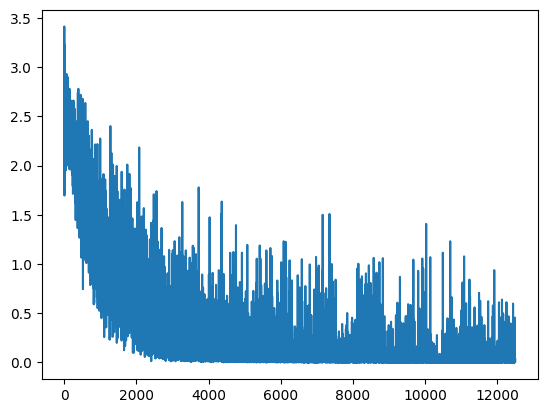

In [8]:
model.train()
for epoch in tqdm(range(num_epochs), position=0, leave=False):
    train_loss = 0.0
    for batch in tqdm(dataloader, leave=False): 
        img, y = batch
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        y = y.to(device)
        y_hat = model(img)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

plt.plot(losses)
plt.show()

In [9]:
model.eval()
total, correct = 0, 0
for x, y in dataloader:
    x, y = x.to(device).reshape(-1, 784, 1), y.to(device)
    y_hat = model(x)
    y_hat = torch.argmax(y_hat, dim=-1)
    total += y.shape[0]
    correct += (y_hat == y).sum().item()
accuracy = correct / total
accuracy

0.9934

# MNIST Generation - Overfitting

Given an empty input sequence, learn to generate a single image from MNIST.

In [44]:
torch.manual_seed(42)

model = Sequential(
    nn.Linear(1, 128),
    *[Block(128, 64) for _ in range(3)],
    nn.Linear(128, 1),
    nn.Sigmoid(),
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.CrossEntropyLoss()
losses = []

img, _ = next(iter(testloader))
# Convert image to a signal with L = 784 and dimension 1
img = img.to(device).reshape(-1, 784, 1)
x = img[:, :-1, :]  # First L-1 elements
zero = torch.zeros_like(x)
y = img[:, 1:, :]   # Last L-1 elements

  0%|          | 0/500 [00:00<?, ?it/s]

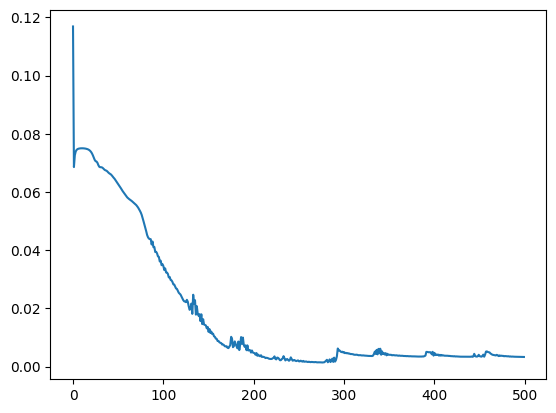

In [45]:
model.train()
for epoch in tqdm(range(500), position=0, leave=True):
    # For each sample i, predict the next sample (i+1) from the slice between 0 to i
    y_hat = model(zero)
    loss = criterion(y_hat, y)

    loss_val = loss.detach().cpu().item()
    losses.append(loss_val)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(losses)
plt.show()

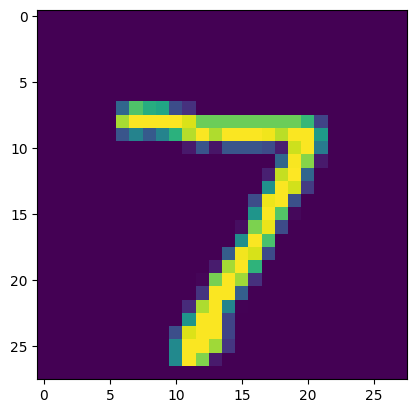

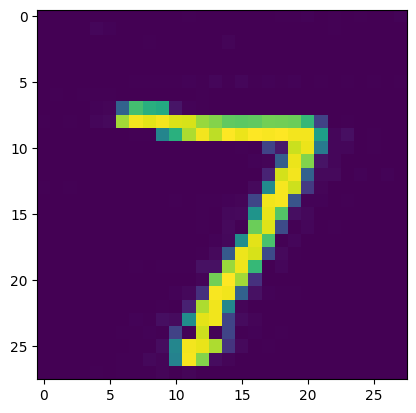

In [56]:
model.eval()

with torch.no_grad():
    y_hat = model(zero)
    img = img.cpu()
    y_hat = y_hat.cpu()
    newimg = torch.cat([img[:,0:1,:], y_hat], dim=1)
    plt.figure()
    plt.imshow(img.reshape(28, 28, 1))
    plt.figure()
    plt.imshow(newimg.reshape(28, 28, 1))

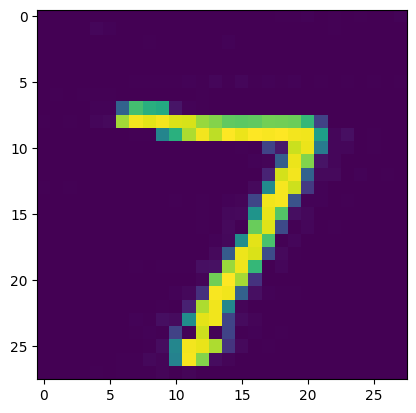

In [58]:
model.eval()

with torch.no_grad():
    start = 783
    #sample = model.autoregressive_sample(784-start, zero[0, :start, :].to(device)).cpu()
    f = model.get_recurrent_runner(783)

    Y = []
    for u in zero[0]:
        y = f(u)
        Y.append(y)
    
    sample = torch.stack([Y[0]]+Y).real

    plt.figure()
    plt.imshow(sample.cpu().reshape(28, 28, 1))

# MNIST Generation

Predict the next pixel based on the given sequence of pixels.

In [121]:
torch.manual_seed(13)

model = Sequential(
    nn.Linear(1, 512),
    *[Block(512, 64) for _ in range(6)],
    nn.Linear(512, 256),
    #nn.Sigmoid(),
)

model.to(device)

L = 1

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = torch.nn.MSELoss()
criterion = torch.nn.CrossEntropyLoss()
losses = []

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

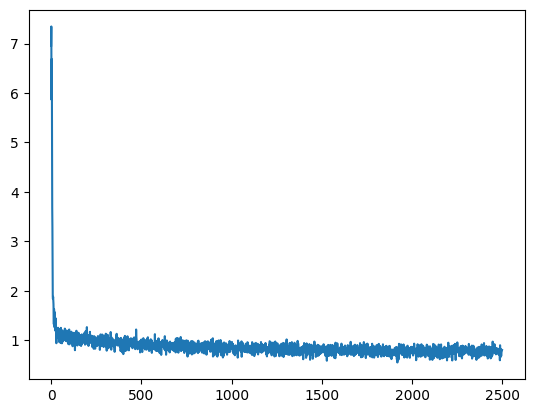

In [122]:
for epoch in tqdm(range(2), position=0, leave=True):
    train_loss = 0.0
    for batch in tqdm(dataloader, leave=False): 
        img, _ = batch
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        x = img[:, :-1, :]  # First L-1 elements
        y = img[:, 1:, :]   # Last L-1 elements
        # For each sample i, predict the next sample (i+1) from the slice between 0 to i
        y_hat = model(x)
        
        y = torch.mul(y, 255.0)
        y = y.to(torch.int64).to(device)[:,:,0]
        #__import__('pdb').set_trace()

        #y = torch.nn.functional.one_hot(y.squeeze(-1), num_classes=256).to(torch.float32)

        #print(f"y[0]: {torch.argmax(y[0][200])}")
        #print(f"y_hat[0]: {y_hat[0]}")
        loss = criterion(y_hat.reshape(-1, 256), y.reshape(-1))

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss}")

plt.plot(losses)
plt.show()

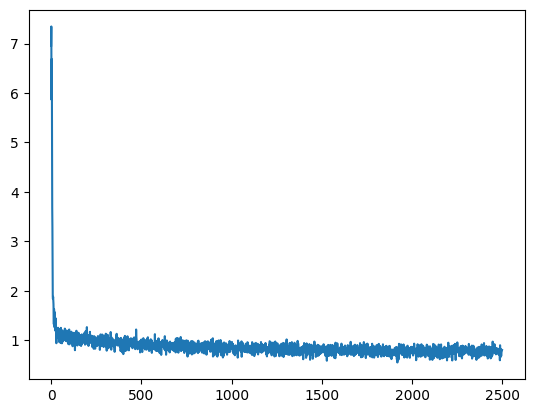

In [123]:
plt.plot(losses)
plt.show()

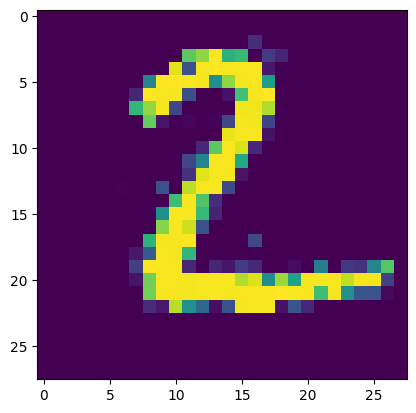

In [124]:
model.eval()

with torch.no_grad():
    img, _ = MNIST_TEST[1]
    img = img.to(device).reshape(-1, 784, 1)
    x = img[:, :-1, :]  # First L-1 elements
    y = img[:, 1:, :]   # Last L-1 elements
    y_hat = model(x)
    img = img.cpu()
    y_hat = y_hat.cpu()
    dist = torch.distributions.categorical.Categorical(probs=torch.nn.functional.softmax(y_hat, dim=-1))
    p = dist.sample()
    #p = torch.argmax(y_hat, dim=-1)
    p = p/255.0
    newimg = torch.cat([img[:,0:1,0], p], dim=1)
    #plt.figure()
    #plt.imshow(img.reshape(28, 28, 1))
    plt.figure()
    plt.imshow(newimg.reshape(28, 28, 1))

In [76]:
def autoregressive_sample(m, samples: int, signal):
    L = (samples + signal.size(dim=-2)) if signal is not None else samples
    f = m.get_recurrent_runner(L)

    # Process the given signal
    for s in signal:
        u = f(s)

        dist = torch.distributions.categorical.Categorical(probs=torch.nn.functional.softmax(u, dim=-1))
        p = dist.sample() / 255.0
        u = p.reshape(1)
    #__import__('pdb').set_trace()

    # Generate the new part
    Y = []
    for _ in range(samples):
        y = f(u)
        dist = torch.distributions.categorical.Categorical(probs=torch.nn.functional.softmax(y, dim=-1))
        p = dist.sample() / 255.0
        Y.append(p)
        u = p.reshape(1)

    generated = torch.stack(Y).real
    if signal is not None:
        return torch.cat([signal.flatten(), generated], dim=0)
    else:
        return generated


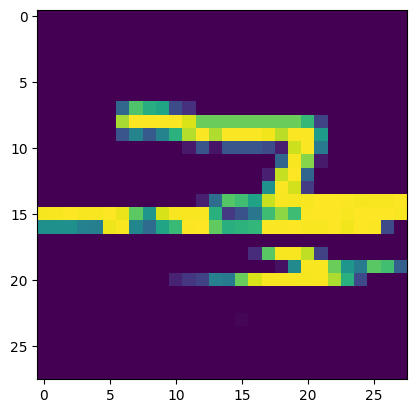

In [133]:
model.eval()

with torch.no_grad():
    img, _ = MNIST_TEST[0]
    img = img.to(device).reshape(-1, 784, 1)
    start = 400
    sample = autoregressive_sample(model, 784-start, img[0, :start, :]).cpu()
    plt.figure()
    plt.imshow(sample.reshape(28, 28, 1))